# PREDICCIÓN DEL CONSUMO DE ENERGÍA USANDO REDES LSTM

##  Problema

Queremos desarrollar un modelo que sea capaz de aprender el patrón de comportamiento en una serie de tiempo (la demanda de Energía Eléctrica) en una región de Estados Unidos, y que posteriormente logre predecir cómo se comportará esta demanda en un futuro cercano.

![](https://drive.google.com/uc?export=view&id=1UaTeYJVVeHxA2nUX2d9tQIZJ8TiDPEAt)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

## El set de datos

El dataset proviene de una empresa distribuidora de Energía Eléctrica en Estados Unidos (PJM Interconnection LLC), y contiene el comportamiento histórico de la demanda (en MegaWatts) entre los años 2004 y 2018 para la ciudad de Dayton (Ohio). Los registros se realizaron con una periodicidad de 1 hora.

In [24]:
ruta = 'DAYTON_hourly_2004_2018.csv'

# Leer el set de datos
datos = pd.read_csv(ruta, index_col=0, parse_dates=True)
datos.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


El set de datos tiene un total de 121,275 registros

In [25]:
datos.shape

(121275, 1)

Ordenamiento cronológico

In [26]:
# Y organizar cronológicamente
datos.sort_index(inplace=True)

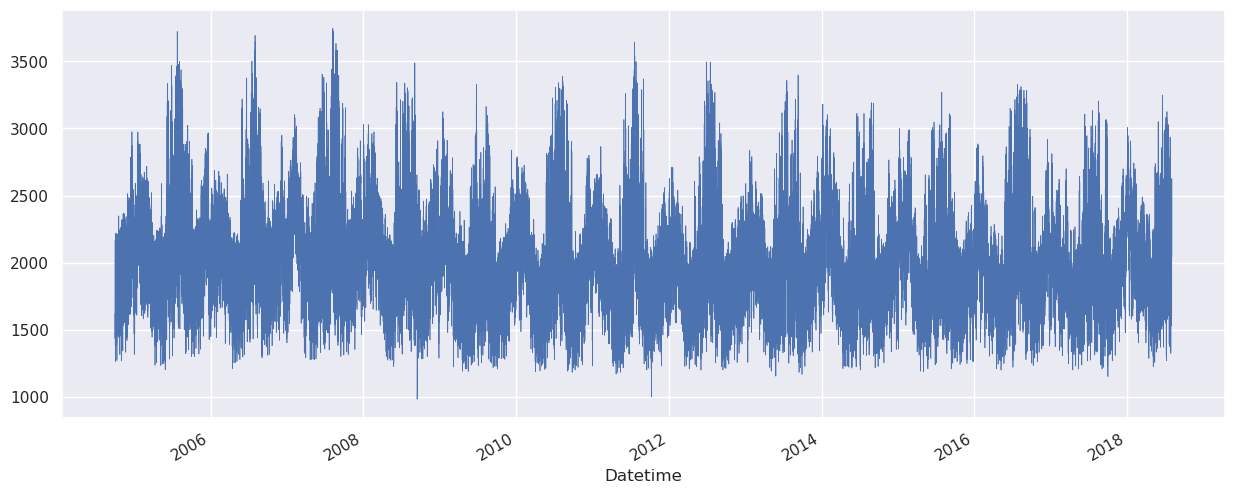

In [27]:
sns.set(rc={'figure.figsize':(15, 6)})

# Dibuja los datos de esa columna
datos['DAYTON_MW'].plot(linewidth=0.5);

## Sets de entrenamiento y prueba

Como entrada al modelo usaremos bloques de 200 datos consecutivos (`X_train`) y el modelo deberá aprender a predecir el dato 201 de la secuencia (`Y_train`):

![](https://drive.google.com/uc?export=view&id=1_VqvozHTfjVrzzJzBAII3pIendriES40)

In [28]:
def dividir_train_test(datos:pd.DataFrame, train_size)-> tuple[pd.DataFrame]:
    idx = round(len(datos)*train_size)
    return idx, datos[0:idx], datos[idx:]

In [29]:
def crear_set_traint_test(df_train:pd.DataFrame, df_test:pd.DataFrame, long_sec: int) -> tuple[pd.DataFrame]:
    X_train, Y_train = [], []
    for i in range(len(df_train)-long_sec):
        X_train.append(df_train[i:i+long_sec])
        Y_train.append(df_train[i+long_sec])

    X_test, Y_test = [], []
    for i in range(len(df_test)-long_sec):
        X_test.append(df_test[i:i+long_sec])
        Y_test.append(df_test[i+long_sec])

    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Cambiamos el tamaño a x1 por (ejemplos_train, 200, 1)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, Y_test

In [30]:
DATOS = datos['DAYTON_MW'].values
TRAIN_SIZE = 0.9

idx, datos_train, datos_test = dividir_train_test(DATOS, TRAIN_SIZE)

In [31]:
datos_train.reshape(-1,1).shape

(109148, 1)

In [32]:
# Escalemos los datos entre -1 y 1 (por la tanh)
MIN, MAX = -1, 1
scaler = MinMaxScaler(feature_range=(MIN,MAX))
datos_train_s = scaler.fit_transform(datos_train.reshape(-1,1))
datos_test_s = scaler.transform(datos_test.reshape(-1,1))

Creación del set de entrenaiento y prueba

In [33]:
LONG_SEC = 350
X_train, Y_train, X_test, Y_test = crear_set_traint_test(datos_train_s, datos_test_s, LONG_SEC)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# 108948 sets de 200 ejemplos cada uno

(108798, 350, 1) (108798, 1)
(11777, 350, 1) (11777, 1)


In [34]:
ID = 623
print(f'Ejemplo {ID}:')
print(f'   Entrada: {X_train[ID,:,:].T}')
print(f'   Salida: {Y_train[ID]}')

Ejemplo 623:
   Entrada: [[-4.26917511e-01 -5.18813314e-01 -5.83212735e-01 -5.98408104e-01
  -6.09985528e-01 -5.83936324e-01 -4.93487699e-01 -3.03183792e-01
  -1.54848046e-01 -1.30969609e-01 -1.27351664e-01 -1.13603473e-01
  -1.22286541e-01 -1.25904486e-01 -1.26628075e-01 -1.41099855e-01
  -1.64254703e-01 -1.60636758e-01 -1.64978292e-01 -1.33140376e-01
  -8.53835022e-02 -1.15050651e-01 -1.75832127e-01 -2.92329957e-01
  -4.10274964e-01 -5.02170767e-01 -5.50651230e-01 -5.75976845e-01
  -5.85383502e-01 -5.61505065e-01 -4.71780029e-01 -2.80752533e-01
  -1.40376266e-01 -1.43270622e-01 -1.44717800e-01 -1.37481910e-01
  -1.50506512e-01 -1.54848046e-01 -1.51953690e-01 -1.63531114e-01
  -1.86685962e-01 -1.85962373e-01 -2.03328509e-01 -2.09117221e-01
  -1.43270622e-01 -1.48335745e-01 -1.98263386e-01 -3.08248915e-01
  -4.14616498e-01 -4.95658466e-01 -5.27496382e-01 -5.55716353e-01
  -5.73806078e-01 -5.49204052e-01 -4.65991317e-01 -2.80028944e-01
  -1.26628075e-01 -1.07814761e-01 -1.15050651e-01 -

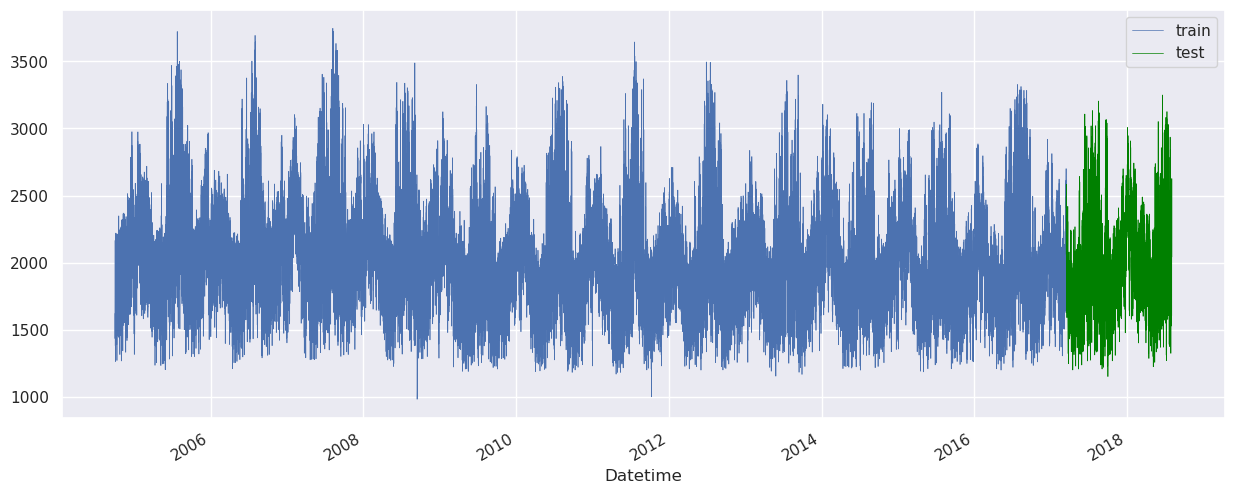

In [35]:
datos['DAYTON_MW'].iloc[0:idx].plot(linewidth=0.5, label='train')
datos['DAYTON_MW'].iloc[idx:].plot(linewidth=0.5, color='green', label='test')
plt.legend();

## 5 - Creación y entrenamiento del modelo

In [36]:
# Tamaño del estado oculto y celda de memoria (Similar al tamaño del LONG_SEC)
N_UNITS = 128
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=(LONG_SEC,1)))
modelo.add(Dense(1))

In [37]:
optimizador = RMSprop(learning_rate=0.0005)
modelo.compile(optimizer=optimizador, loss='mse', metrics='mean_absolute_error')

# Entrenamiento
EPOCHS = 20
BATCH_SIZE = 256
modelo.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
           validation_data = (X_test, Y_test))

Epoch 1/20
425/425 [==============================] - 11s 24ms/step - loss: 0.0142 - mean_absolute_error: 0.0874 - val_loss: 0.0035 - val_mean_absolute_error: 0.0465
Epoch 2/20
425/425 [==============================] - 10s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0452 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326
Epoch 3/20
425/425 [==============================] - 10s 22ms/step - loss: 0.0019 - mean_absolute_error: 0.0330 - val_loss: 0.0015 - val_mean_absolute_error: 0.0293
Epoch 4/20
425/425 [==============================] - 10s 23ms/step - loss: 0.0015 - mean_absolute_error: 0.0296 - val_loss: 0.0012 - val_mean_absolute_error: 0.0262
Epoch 5/20
425/425 [==============================] - 9s 22ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0011 - val_mean_absolute_error: 0.0245
Epoch 6/20
425/425 [==============================] - 10s 23ms/step - loss: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 0.0010 - val_mean_absolute_error: 0.0237
Epoch

##  Predicción

Verifiquemos inicialmente qué tan bien se genera la predicción sobre cada dato de prueba en `X_test`:

In [38]:
# Predicción (1 muestra, single-step)
y_pred = [y[0] for y in modelo.predict(X_test)]
y_pred = np.array(y_pred)
print(X_test.shape)
print(len(y_pred))

369/369 [==============================] - 2s 4ms/step
(11777, 350, 1)
11777


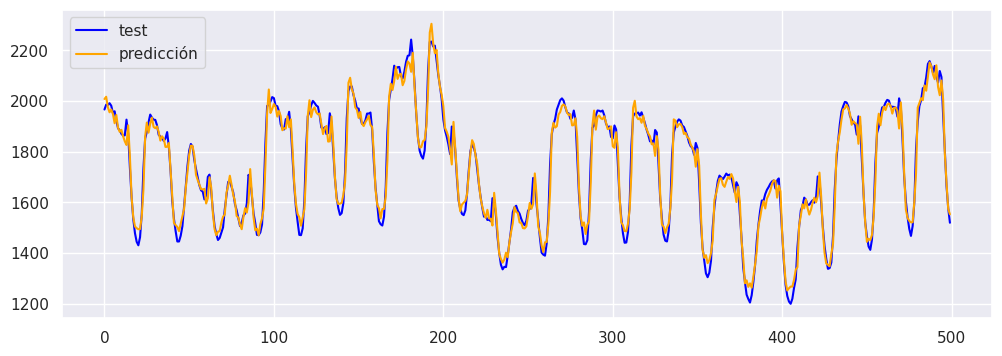

In [39]:
# Predicciones en la escala original
y_test_inv = scaler.inverse_transform(Y_test)

y_pred_inv = y_pred.reshape(-1,1)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:500],color='blue',label='test')
plt.plot(y_pred_inv[0:500],color='orange',label='predicción')
plt.legend();

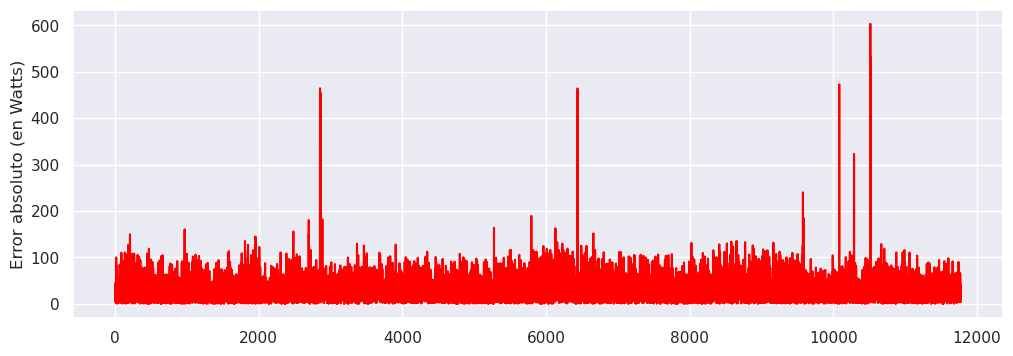

In [40]:
# Gráfica del error absoluto
plt.figure(figsize=(12,4))
plt.plot(np.abs(y_test_inv-y_pred_inv), color='red');
plt.ylabel('Error absoluto (en Watts)');

Ahora haremos predicción *multi-step*: en lugar de predecir un sólo dato vamos a predecir una secuencia completa:

In [41]:
# Tomar la primera parte de X_test como punto de inicio
x_pred = X_test[0,:,:].reshape(1,LONG_SEC,1)

# Iterativamente predecir y201 = pred(x1,x2,...,x200),
# y202 = pred(x2, x3, x4,..., x200, y201), etc...

N_preds = 4000
y_preds = []    

for i in range(N_preds):

  pred = modelo.predict(x_pred)
  y_preds.append(pred[0])

  x_pred = np.append(x_pred,pred[0])

  x_pred = np.delete(x_pred,0)

  x_pred = np.reshape(x_pred,(1,LONG_SEC,1))

1/1 [==============================] - 0s 14ms/step


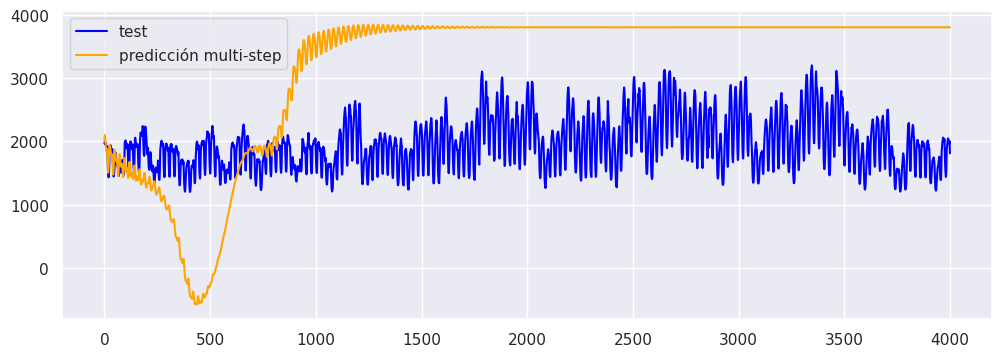

In [42]:
# Regresamos las predicciones en la escala original
y_preds = np.array(y_preds).reshape(-1,1)
y_preds = scaler.inverse_transform(y_preds)

# Comparación gráfica con el set de prueba original
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:N_preds],color='blue',label='test')
plt.plot(y_preds[0:N_preds],color='orange',label='predicción multi-step')
plt.legend();

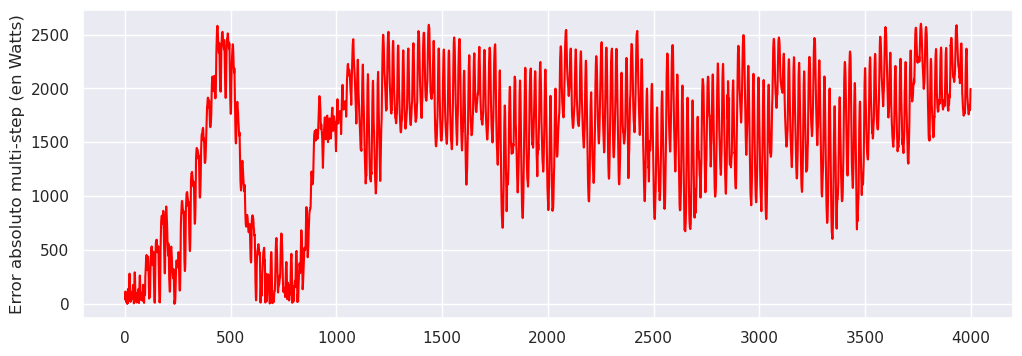

In [43]:
# Veamos el error absoluto en estas predicciones

plt.figure(figsize=(12,4))
plt.plot(np.abs(y_test_inv[0:N_preds]-y_preds[0:N_preds]), color='red')
plt.ylabel('Error absoluto multi-step (en Watts)');

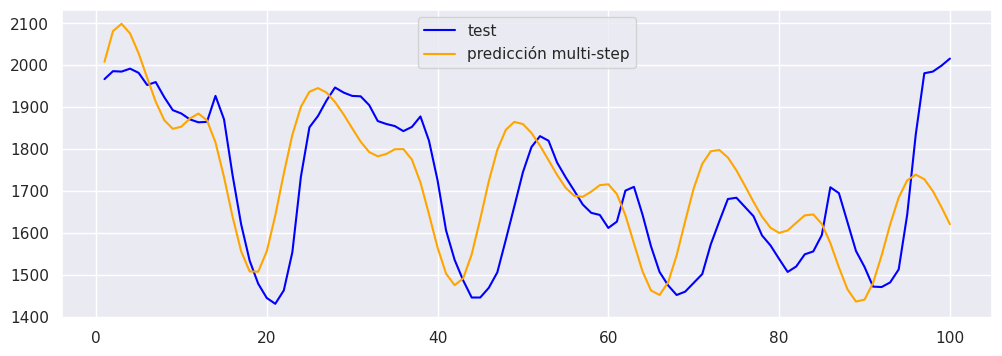

In [44]:
HRS = 100
plt.figure(figsize=(12,4))
plt.plot(range(1,HRS+1),y_test_inv[0:HRS],color='blue',label='test')
plt.plot(range(1,HRS+1),y_preds[0:HRS],color='orange',label='predicción multi-step')
plt.legend();